## **Import n√©cessaire au fonctionnement du code**

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge gmpy2

‚è¨ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
üì¶ Installing...
üìå Adjusting configuration...
ü©π Patching environment...
‚è≤ Done in 0:00:12
üîÅ Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gmpy2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    gmp-6.3.0                  |       hac33072_2         449 KB  conda-forge
    gmpy2-2.1.5                |  py311h0f6cedb_3         198 KB  conda-forge
    mpc-1.3.1     

In [ ]:
from gmpy2 import root, mpfr, cbrt, sqrt, c_div, is_prime, random_state, mpz_urandomb
from gmpy2 import bit_set, next_prime, bit_length, num_digits, mpz_random, gcd
from gmpy2 import invert, powmod, mpz
import time
import random

In [ ]:
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt


### **Pr√©-traitement**

In [ ]:
#Conversion d'une image en niveau de gris
#R√©cup√©ration de la matrice des pixels cod√©s sur 8 bits

def image_to_grayscale_matrix(image_path):
    # Ouvrir l'image
    image = Image.open(image_path)

    # Convertir l'image en niveaux de gris
    grayscale_image = image.convert("L")

    # Convertir l'image en une matrice numpy
    grayscale_matrix = np.array(grayscale_image, dtype=np.uint8)

    return grayscale_matrix

In [ ]:
#D√©coupage d'une matrice en bloc de taille s
def decouper_mat(matrice,s):
    h, w = matrice.shape
    # Convertir la matrice en une liste plate
    liste_plate = matrice.flatten()
    # D√©couper la liste plate en sous-listes de taille s
    listes = [liste_plate[i:i +s] for i in range(0, len(liste_plate),s)]
    return listes

#Reconstruction de la matrice √† partir des blocs de taille s
def reconstruire_matrice(listes, h, w):
    # Aplatir toutes les listes pour former une grande liste
    liste_plate = [item for sublist in listes for item in sublist]
    # Convertir la liste plate en une matrice de taille (h, w)
    matrice_reconstruite = np.array(liste_plate).reshape(h, w)
    return matrice_reconstruite

In [ ]:
#G√©n√©ration d'une marque al√©atoire de taille s
def generate_marque(s):
  premarque = np.random.randint(0, 2, size=s)
  return premarque

In [ ]:
#D√©finition de l'algorithme de tatouage QIM (Quantization Index Modulation)
def mod_QIM(b,m,D):
  if (m//D)%2==b:
    I_marq_i=(m//D)*D
  else:
    if m==255 and b==0:
      I_marq_i=(m//D)*D-D #√©viter la distorsion de l'image
    else:
      I_marq_i=(m//D)*D+D
  return I_marq_i

In [ ]:
#Premarquage de la matrice de pixel
#Application de l'algorithme de QIM √† chaque pixel
def premarquage(premarque,I_v,D):
  I_marq=np.zeros(np.shape(I_v))
  #on parcourt l'ensemble des pixels que la matrice de blocs de taille s
  for i in range (np.shape(I_v)[0]):
    for j in range (np.shape(I_v)[1]):
      #on y applique l'algorithme de QIM
      I_marq[i][j]=mod_QIM(premarque[j],I_v[i][j],D)
  return I_marq

In [ ]:
## Ce script contient l'ensemble des fonctions n√©cessaires
## √† la g√©n√©ration de clefs, le chiffrement et le d√©chiffrement de Paillier

def get_prime(size): # size is the binary size
    # Get a random prime number of the specified bit size
    seed= random_state(time.time_ns())
    p = mpz_urandomb(seed,size)
    p = p.bit_set(size - 1)  # Ensure the number has exactly 'size' bits
    p = next_prime(p)

    # Verify primality using gmpy2's is_prime
    if is_prime(p) and p.bit_length() == size:
        return p
    return get_prime(size)

def get_paillier_keys(size):
  # Generate two large primes p and q (each of size/2 bits)
  p=get_prime(size // 2)
  q=get_prime(size // 2)
  while p==q:
    q=get_prime(size//2)

  # Calculate N = p*q
  N=p*q
  # Calculate phi(N) = (p-1)(q-1)
  phi_N= (p-1)*(q-1)
  # Set g = 1 + N
  g=1+N
  # Return public key (N, g) and private key (phi, p, q)
  pub_key=(N, g)
  priv_key=(phi_N, p, q)
  return pub_key, priv_key

def get_r(pub_key):
  # Generate a random number r with gcd(r, N) = 1
  N=pub_key[0]
  seed= random_state(time.time_ns())
  r=mpz_random(seed,N)
  while gcd(r,N)!=1 or r<3:
    seed= random_state(time.time_ns())
    r=mpz_random(seed,N)
  return r

def paillier_encrypt(message, pub_key):
  # Encrypt the message using Paillier cryptosystem
  # N = pub_key[0], g = pub_key[1]
  N = pub_key[0]
  g = pub_key[1]
  m=message
  r=get_r(pub_key)
  # c = (g^m * r^N) mod N^2
  c= (powmod(g,m,N**2)*powmod(r,N,N**2))%N**2
  return c

def paillier_decrypt_CRT(enc, priv_key, pub_key):
  #Decrypt using Chinese Remainder Theorem for improved performance
  phi_N=priv_key[0]
  p=priv_key[1]
  q=priv_key[2]

  N=pub_key[0]
  #L(u) = (u-1)/N
  u_p=powmod(enc,phi_N,p**2)
  u_q=powmod(enc,phi_N,q**2)

  v=(invert(q**2,p**2)*(u_p-u_q))%p**2
  u=u_q+v*q**2
  L_u=(u-1)//N

  inv_mu=invert(phi_N,N)

  # m = L(c^lambda mod N^2) * mu mod N
  m=(L_u*inv_mu)%N
  return m

In [ ]:
# Chiffrement de Paillier des pixels marqu√©s de la matrice
def premarquage_encryption(I_v,pub_key):
  I_marq_enc=np.zeros(np.shape(I_v),dtype=object)
  for i in range (np.shape(I_v)[0]):
    if((i/np.shape(I_v)[0])*100)%5==0:print((i/np.shape(I_v)[0])*100) #permet d'afficher en pourcentage l'avancement du chiffrement
    for j in range (np.shape(I_v)[1]):
      message = I_v[i][j]
      # Chiffrement
      I_marq_enc[i][j]= paillier_encrypt(mpz(message), pub_key)
  return I_marq_enc

In [ ]:
# D√©chiffrement de Paillier des pixels
def premarquage_decryption(I_v, priv_key, pub_key):
  I_marq_dec=np.zeros(np.shape(I_v),dtype=object)
  for i in range (np.shape(I_v)[0]):
    if((i/np.shape(I_v)[0])*100)%5==0:print((i/np.shape(I_v)[0])*100) #permet d'afficher en pourcentage l'avancement du chiffrement
    for j in range (np.shape(I_v)[1]):
      # Decrypt
      I_marq_dec[i][j]= paillier_decrypt_CRT(mpz(I_v[i][j]), priv_key, pub_key)
  return I_marq_dec

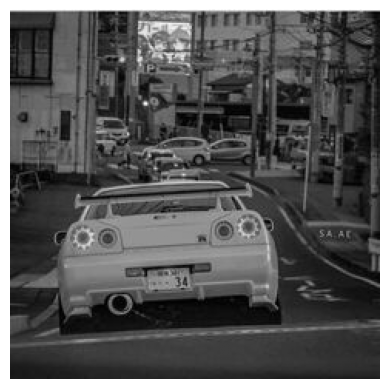

0.0
20.0
40.0
60.0
80.0
0.0
20.0
40.0
60.0
80.0


In [ ]:
## TEST de la partie Pr√©traitement

# Acc√©der √† l'image via le nom du fichier import√© dans l'espace Google Colab
image_path = 'image_projet.jpg'  # Remplace par le nom du fichier t√©l√©charg√©

# Conversion de l'image en niveau de gris et matrice de pixel cod√© sur 8 bits
grayscale_matrix = image_to_grayscale_matrix(image_path)
#print(grayscale_matrix)

# Affichage de la matrice de pixel
plt.imshow(grayscale_matrix, cmap='gray')
plt.axis('off')  # Masquer les axes
plt.show()

# G√©n√©ration d'une pr√©marque al√©atoire de taille 256
premarque=generate_marque(256)
#print("premarque=",premarque)

# D√©coupage de la matrice de pixels en bloc de taille s
listes=decouper_mat(grayscale_matrix,256)
#print("listes=",listes[0])

# Pr√©marquage de la matrice de pixels √† l'aide de l'algorithme de QIM
listes_premarq=premarquage(premarque,listes,1)# D=1
#print("listes_premarq=",listes_premarq[0])

# G√©n√©ration des clefs de Paillier
pub_key, priv_key = get_paillier_keys(256)
#print("pub_key=",pub_key)
#print("priv_key=",priv_key)

# Chiffrement de Paillier des pixels pr√©marqu√©s de la matrice -- Attention l'ex√©cution de cette fonction n√©cessite quelques minutes
listes_marq_enc=premarquage_encryption(listes_premarq,pub_key)#chiffrement du premarquage en 256 bit
#print("listes_marq_enc=",listes_marq_enc[0])

# V√©rification en calculant le d√©chiffrement des pixels de la matrice
listes_marq_dec=premarquage_decryption(listes_marq_enc,priv_key,pub_key)
#print("listes_marq_dec=",listes_marq_dec[0])

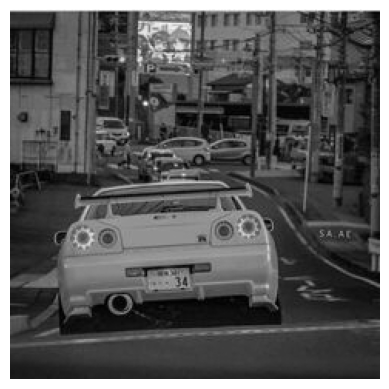

In [ ]:
# TEST affichage de l'image apr√®s premarquage

# Reconstruction de l'image et conversion en float
image=reconstruire_matrice(listes_marq_dec.astype(float),np.shape(grayscale_matrix)[0],np.shape(grayscale_matrix)[1])

# Affichage de la matrice de piel
plt.imshow(image, cmap='gray')
plt.axis('off') # Masquer les axes
plt.show()

## **Insertion dans le domaine clair**

In [ ]:
# Insertion d'un message dans le domaine clair de l'image
# Application de l'√©quation 3 du sujet

def ins1(I_v,message,pub_key):
  I_ins1=np.zeros(np.shape(I_v),dtype=object)
  enc_m=np.zeros(np.shape(I_v)[1],dtype=object)
  for j in range (np.shape(I_v)[1]):
    # Chiffrement de Paillier du bit du message √† ins√©rer
    enc_m[j] = paillier_encrypt(mpz(message[j]), pub_key)
    for i in range (np.shape(I_v)[0]):
      I_ins1[i][j]=(I_v[i][j]*enc_m[j])%pub_key[0]**2
      # ajout du bit du message dans le pixel de l'image en profitant de la propri√©t√© homomorphique du chiffrement de Paillier
      # le produit des deux chiffr√©s doit rester dans le groupe (N**2,*)
  return I_ins1

0.0
20.0
40.0
60.0
80.0


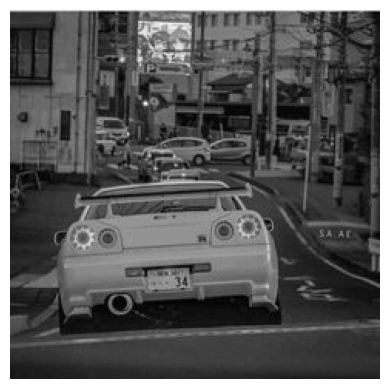

In [ ]:
## TEST insertion dans le domaine clair

# G√©n√©ration d'un message al√©atoire √† tatouer
message=generate_marque(256)# message √† tatouer de taille s=256
#print("message=",message)

# Insertion du message dans le domaine clair
#r√©cup√©ration de la matrice pr√©marqu√©e et chiffr√©√©
I_enc_ins1=ins1(listes_marq_enc,message,pub_key)
#print(I_enc_ins1[0])

# D√©chiffrement de la matrice tatou√©e par le message dans le domaine clair
dec_I_in1=premarquage_decryption(I_enc_ins1,priv_key,pub_key)
#print(dec_I_in1[0])

#test affichage de l'image apr√®s insertion
image=reconstruire_matrice(dec_I_in1.astype(float),np.shape(grayscale_matrix)[0],np.shape(grayscale_matrix)[1])
# Affichage de la matrice binaire
plt.imshow(image, cmap='gray')
plt.axis('off') # Masquer les axes
plt.show()



## **Insertion dans le domaine chiffr√©**

In [ ]:
# Insertion d'un message dans le domaine chiffr√© de l'image (c'est-√†-dire sur l'image chiffr√©e)

def ins2(I_ins1,message,pub_key):
  I_ins2=np.copy(I_ins1)
  for i in range (np.shape(I_ins2)[0]):

    if((i/np.shape(I_ins2)[0])*100)%5==0:print((i/np.shape(I_ins2)[0])*100) #permet d'afficher en pourcentage l'avancement de l'insertion

    for j in range (np.shape(I_ins2)[1]):

      while (I_ins2[i][j])%2!=mpz(message[j]): #tant que le pixel chiffr√© n'a pas la m√™me parit√© que le bit du message √† tatouer ...
        #print("in")
        #print((I_ins2[i][j]),message[j])

        I_ins2[i][j]=(I_ins2[i][j]*paillier_encrypt(mpz(0), pub_key))%pub_key[0]**2
        #modification de la parit√© du pixel chiffr√© sans modifi√© le pixel en clair (√† l'aide de la propri√©t√© homomorphique du chiffrement Paillier)
        #√† chaque it√©ration le chiffr√© de 0 est diff√©rent gr√¢ce aux propri√©t√©s s√©mantiquement s√ªres du chiffrement de Paillier
        #le produit des deux chiffr√©s doit rester dans le groupe (N**2,*)

      #print("out")
  return I_ins2

In [ ]:
## TEST insertion dans le domaine chiffr√©

# On r√©cup√®re la matrice chiffr√©e pr√©c√©dente dans laquelle on a tatou√© dans le domaine claire le message
# On r√©cup√®re √©galement le message √† tatouer pr√©c√©dement g√©n√©r√© de mani√®re al√©atoire
I_enc_ins1_ins2=ins2(I_enc_ins1,message,pub_key) #-- Attention l'ex√©cution de cette fonction n√©cessite quelques minutes
print(I_enc_ins1_ins2)



0.0
20.0
40.0
60.0
80.0
[[mpz(991847702158611916996637064857109939453804192344233512735941436245031348140909975468460678653730622533877604241076812818457530465436186527463413783053933)
  mpz(1467092103723806318924693022299253410476410047815173070605400452375730976131721973703712635273179510444270306056355229270838586974183244173341031936268459)
  mpz(167259072064545682317900064253566298619774661299029089706386582513681085942332271065599296133214504352186490640881907089469925509637411335122072596720420)
  ...
  mpz(329404207795703412537748029707259675077972947958355542299822421075629329799240847215287809227029683888407484455073161910740377420884624560904458170302279)
  mpz(510236540965119898754833957416945215187197664894960367326917804012714598580194938719446238582964013094569895078944513907220963822324512317390864542778421)
  mpz(1042487366533177737363664842888062886995368469028421396826180135582757533833943154597072514886180573338690658793166581146797827229636338131503989060165549)]
 

## **Extraction dans le domaine chiffr√©**

In [ ]:
# Extraction du message tatou√© dans le domaine chiffr√©

def ext1(I_enc_ins1_ins2):
  message_ext1=np.zeros(np.shape(I_enc_ins1_ins2),dtype=object)
  for i in range (np.shape(I_enc_ins1_ins2)[0]):
    for j in range (np.shape(I_enc_ins1_ins2)[1]):
      #on extrait le j-√®me bit du message, en calculant le modulo 2 du j-i√®me pixel
      message_ext1[i][j]=(I_enc_ins1_ins2[i][j])%2
  if np.all(message_ext1 == message_ext1[0], axis=1).all():
    #comme on extrait un message √† partir de chaque bloc
    #il est n√©cessaire de comparer les messages extraits des diff√©rents blocs pour s'assurer de l'int√©grit√©
    return(message_ext1[0]) # s'il y a pas d'erreur d'int√©grit√©, on retourne le message extrait du premier bloc

  return "integrity error" #si un message extrait d'un bloc diff√®re des autres messages extraits, une erreur d'int√©grit√© est renvoy√©e

In [ ]:
## TEST extraction dans le domaine chiffr√©

#on r√©cup√®re la matrice g√©n√©r√©e en sortie de l'insertion dans le domaine chiffr√©
message_ext_enc=ext1(I_enc_ins1_ins2)
#print(message_ext_enc)

#on compare le message extrait du domaine chiffr√© avec le message tatou√© √† l'origine:
print((message_ext_enc==message).all()) #renvoie True si les deux messages sont √©gaux

True


## **Extraction dans le domaine clair**

In [ ]:
# Extraction du message tatou√© dans le domaine clair

def ext2(I_v_ins1,premarque,D):
  message_ext1=np.zeros(np.shape(I_v_ins1)[1],dtype=object)
  message_ext2=np.zeros(np.shape(I_v_ins1),dtype=object)

  for i in range (np.shape(I_v_ins1)[0]):

    for j in range (np.shape(I_v_ins1)[1]):
      message_ext1[j]=(I_v_ins1[i][j]//D)%2
      #extraction du j-i√®me bit du message1 √† partir du j-i√®me pixel de la matrice

    message_ext2[i]=message_ext1 ^ premarque
    #calcul du XOR entre la message1 extrait du bloc i et la premarque
    #ainsi on extrait le message du i-√®me bloc de la matrice

  if np.all(message_ext2 == message_ext2[0], axis=1).all():
    #comme on extrait un message √† partir de chaque bloc
    #il est n√©cessaire de comparer les messages extraits des diff√©rents blocs pour s'assurer de l'int√©grit√©
    return(message_ext2[0]) # s'il y a pas d'erreur d'int√©grit√©, on retourne le message extrait du premier bloc

  return "integrity error" #si un message extrait d'un bloc diff√®re des autres messages extraits, une erreur d'int√©grit√© est renvoy√©e


In [ ]:
## TEST extraction dans le domaine clair

#r√©cup√©ration la matrice [d√©chiffr√©e] apr√®s l'insertion dans le domaine clair et la pr√©marque
message_ext_clair=ext2(dec_I_in1,premarque,1) #D=1
#print(message_ext_clair)

#on compare le message extrait du domaine clair avec le message tatou√© √† l'origine:
print((message==message_ext_clair).all()) #renvoie True si les deux messages sont √©gaux

True
